In [5]:
import os
import time
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy import stats
from pylab import rcParams
from sklearn.utils import check_random_state
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, \
    GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

# Importing random forest model and libraries
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
from sklearn.model_selection import cross_val_score
import scipy as sp
import pickle as pkl
%matplotlib inline

In [6]:
import pandas as pd
if True:
    df_P100 = pd.read_csv('p100_all_data.csv', index_col = 0)
    df_V100 = pd.read_csv('v100_all_data.csv', index_col = 0)
    new_df = pd.read_csv('new_df.csv', index_col = 0)
    all_data = pd.read_csv('all_data.csv', index_col = 0)
if True:
    all_data = all_data.dropna(axis=1,how='any')

In [7]:
## new_df = P100 Metrics with V100 IPC
df_new = new_df

#grabbing IPC values
newdf_ipc = df_new.drop(columns=['shared_utilization','stall_other','single_precision_fu_utilization','architecture','input','application_name','kernelname'])
newdf_ipc = newdf_ipc['ipc']
new_ipc_values = newdf_ipc.values

df_new_norm = df_new.drop(columns=['shared_utilization','stall_other','single_precision_fu_utilization','architecture','input','application_name','kernelname','ipc'])
df_new_norm = df_new_norm.values
df_new_norm = MinMaxScaler().fit_transform(df_new_norm)

# Import `train_test_split` from `sklearn.model_selection`
from sklearn.model_selection import train_test_split
X_new = df_new_norm
Y_new = new_ipc_values

# Split the data up in train and test sets
X_trainnew, X_testnew, y_trainnew, y_testnew = train_test_split(X_new, Y_new, test_size=0.33, random_state=42)



In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# Creates array of ipc values and array of metrics 
def process(new_df,test_size):
    ipc_values = new_df['ipc'].values
    new_def_norm = new_df.drop(columns=['shared_utilization','stall_other','single_precision_fu_utilization','architecture','input','ipc','application_name','kernelname'])

    #v100+p100 combined
    new_def_norm_values = new_def_norm.values
    new_def_norm = MinMaxScaler().fit_transform(new_def_norm_values)

    ###!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!####
    X_VP = new_def_norm 
    Y_VP = ipc_values

    # Split the data up in train and test sets
    X_trainVP, X_testVP, y_trainVP, y_testVP = train_test_split(X_VP, Y_VP, test_size=test_size, random_state=False)

    # Import `StandardScaler` from `sklearn.preprocessing`
    from sklearn.preprocessing import StandardScaler

    # Define the scaler 
    #scalerVP = StandardScaler().fit(X_trainVP)
    scalerVP = StandardScaler().fit(X_trainVP)

    # Scale the train set
    X_trainVP = scalerVP.transform(X_trainVP)

    # Scale the test set
    X_testVP = scalerVP.transform(X_testVP)
    
    return X_trainVP, X_testVP, y_trainVP, y_testVP, X_VP, Y_VP



In [9]:
#Creating two data sets 
from_scratch = False
df = pd.read_csv('all_data.csv', index_col = 0)
df = df.dropna(axis=1,how='any')
if from_scratch:
    df_check = None
    frames = []
    frame2 = []
    df_v = []
    df_p = []
    for name, item in df.groupby(['kernelname', 'input']):
        df_1 = df[ df['kernelname'] == name[0] ]
        df_2 = df_1[ df_1['input'] == name[1] ]
        if len(df_2) == 2:
            df_v = df_2[df_2['architecture'] == 'V100']
            df_p = df_2[df_2['architecture'] == 'P100']
            #df_p['ipc'][0] = df_v.iloc[0]['ipc']
            frames.append(df_p)
            frame2.append(df_v)

    new_df = pd.concat(frames)
    new_v = pd.concat(frame2)

In [98]:
## START HERE

In [10]:
if from_scratch:
    new_df.to_csv('cor_p100.csv')
    new_v.to_csv('cor_v100.csv')
else:
    new_p = pd.read_csv('cor_p100.csv', index_col = 0)
    new_v = pd.read_csv('cor_v100.csv', index_col = 0)

In [11]:
X_trainP, X_testP, y_trainP, y_testP, X_P, Y_P = process(new_p,.2)
X_trainV, X_testV, y_trainV, y_testV, X_V, Y_V = process(new_v,.2)

In [12]:
import numpy
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


# Create your first MLP in Keras
from keras.models import Sequential
from keras.layers import Dense
import numpy
# fix random seed for reproducibility
numpy.random.seed(7)
# load pima indians dataset
#dataset = pd.read_csv("p100_only.csv", delimiter=",").values
# split into input (X) and output (Y) variables
#X = dataset[:,0:8]
#Y = dataset[:,8]
# create model
def my_model():
    model = Sequential()
    """
    #original simple dl model
    model.add(Dense(12, input_dim=112, kernel_initializer='normal',activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1, activation='relu'))"""
    #early stopping, smaller layers, less layers
    model.add(Dense(130, input_dim=112, kernel_initializer='normal',activation='relu'))
    model.add(Dense(120, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dense(90, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dense(110, activation='relu'))
    model.add(Dense(120, activation='relu'))
    model.add(Dense(112, activation=None))
    # Compile model
    #mean absolute percentage error - indicating that we seek to minimize the mean percentage difference between 
    #predicted ipc and the actual ipc
    model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
    # Fit the model
    ## model.fit(X, Y, epochs=10, batch_size=10) ##works

    """
    # evaluate the model
    scores = model.evaluate(X, Y)
    print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))"""
    return model

Using TensorFlow backend.


In [13]:
"""
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

#early stopping - once validation error stops improving, cut it off
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=100, verbose=1, mode='min')
callbacks=earlystop
p_model = my_model()
mc = ModelCheckpoint('filename.h5', monitor='val_loss', mode='min', verbose=1,save_best_only=True)
#callbacks_list = [earlystop, mc]
p_model.fit(X_trainP, X_trainV, epochs=2000, batch_size=10000, verbose=1,validation_split=0.7,callbacks=[earlystop,mc])

"""

"\nfrom keras.callbacks import EarlyStopping\nfrom keras.callbacks import ModelCheckpoint\n\n#early stopping - once validation error stops improving, cut it off\nearlystop = EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=100, verbose=1, mode='min')\ncallbacks=earlystop\np_model = my_model()\nmc = ModelCheckpoint('filename.h5', monitor='val_loss', mode='min', verbose=1,save_best_only=True)\n#callbacks_list = [earlystop, mc]\np_model.fit(X_trainP, X_trainV, epochs=2000, batch_size=10000, verbose=1,validation_split=0.7,callbacks=[earlystop,mc])\n\n"

## Running model with various training data sizes

In [89]:
def testing_training_size(test_size):
    #training size decreases
    new_p = pd.read_csv('cor_p100.csv', index_col = 0)
    new_v = pd.read_csv('cor_v100.csv', index_col = 0)
    X_trainP, X_testP, y_trainP, y_testP, X_P, Y_P = process(new_p,test_size)
    X_trainV, X_testV, y_trainV, y_testV, X_V, Y_V = process(new_v,test_size)
    h_model = my_model()
    history = h_model.fit(X_trainP, X_trainV, epochs=70, batch_size=10000,  verbose=1, validation_split=0.2)
    return history.history['loss']


In [90]:
import numpy as np
#Going through 10 different training set sizes and saving results to val_testsize
val_testsize = {}
for test_size in np.arange(.01, 1, 0.1):
    #print(test_size)
    val_testsize[test_size] = testing_training_size(test_size)


Train on 16300 samples, validate on 4076 samples
Epoch 1/70
16300/16300 [==============================] - 2s 103us/step - loss: 0.8098 - mean_squared_error: 0.8098 - mean_absolute_error: 0.4718 - val_loss: 0.7786 - val_mean_squared_error: 0.7786 - val_mean_absolute_error: 0.4673
Epoch 2/70
16300/16300 [==============================] - 0s 7us/step - loss: 0.7537 - mean_squared_error: 0.7537 - mean_absolute_error: 0.4538 - val_loss: 0.7331 - val_mean_squared_error: 0.7331 - val_mean_absolute_error: 0.4565
Epoch 3/70
16300/16300 [==============================] - 0s 8us/step - loss: 0.7086 - mean_squared_error: 0.7086 - mean_absolute_error: 0.4439 - val_loss: 0.6833 - val_mean_squared_error: 0.6833 - val_mean_absolute_error: 0.4472
Epoch 4/70
16300/16300 [==============================] - 0s 8us/step - loss: 0.6594 - mean_squared_error: 0.6594 - mean_absolute_error: 0.4346 - val_loss: 0.6278 - val_mean_squared_error: 0.6278 - val_mean_absolute_error: 0.4364
Epoch 5/70
16300/16300 [=====

16300/16300 [==============================] - 0s 7us/step - loss: 0.0518 - mean_squared_error: 0.0518 - mean_absolute_error: 0.0975 - val_loss: 0.0665 - val_mean_squared_error: 0.0665 - val_mean_absolute_error: 0.1009
Epoch 37/70
16300/16300 [==============================] - 0s 8us/step - loss: 0.0502 - mean_squared_error: 0.0502 - mean_absolute_error: 0.0953 - val_loss: 0.0647 - val_mean_squared_error: 0.0647 - val_mean_absolute_error: 0.0986
Epoch 38/70
16300/16300 [==============================] - 0s 8us/step - loss: 0.0488 - mean_squared_error: 0.0488 - mean_absolute_error: 0.0932 - val_loss: 0.0631 - val_mean_squared_error: 0.0631 - val_mean_absolute_error: 0.0965
Epoch 39/70
16300/16300 [==============================] - 0s 8us/step - loss: 0.0475 - mean_squared_error: 0.0475 - mean_absolute_error: 0.0913 - val_loss: 0.0618 - val_mean_squared_error: 0.0618 - val_mean_absolute_error: 0.0947
Epoch 40/70
16300/16300 [==============================] - 0s 8us/step - loss: 0.0464 - 

14653/14653 [==============================] - 2s 117us/step - loss: 0.8116 - mean_squared_error: 0.8116 - mean_absolute_error: 0.4927 - val_loss: 0.7814 - val_mean_squared_error: 0.7814 - val_mean_absolute_error: 0.4835
Epoch 2/70
14653/14653 [==============================] - 0s 7us/step - loss: 0.7574 - mean_squared_error: 0.7574 - mean_absolute_error: 0.4734 - val_loss: 0.7318 - val_mean_squared_error: 0.7318 - val_mean_absolute_error: 0.4738
Epoch 3/70
14653/14653 [==============================] - 0s 7us/step - loss: 0.7110 - mean_squared_error: 0.7110 - mean_absolute_error: 0.4649 - val_loss: 0.6829 - val_mean_squared_error: 0.6829 - val_mean_absolute_error: 0.4675
Epoch 4/70
14653/14653 [==============================] - 0s 7us/step - loss: 0.6643 - mean_squared_error: 0.6643 - mean_absolute_error: 0.4586 - val_loss: 0.6299 - val_mean_squared_error: 0.6299 - val_mean_absolute_error: 0.4594
Epoch 5/70
14653/14653 [==============================] - 0s 8us/step - loss: 0.6129 - me

14653/14653 [==============================] - 0s 7us/step - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_error: 0.0999 - val_loss: 0.0773 - val_mean_squared_error: 0.0773 - val_mean_absolute_error: 0.1027
Epoch 37/70
14653/14653 [==============================] - 0s 8us/step - loss: 0.0551 - mean_squared_error: 0.0551 - mean_absolute_error: 0.0979 - val_loss: 0.0761 - val_mean_squared_error: 0.0761 - val_mean_absolute_error: 0.1006
Epoch 38/70
14653/14653 [==============================] - 0s 7us/step - loss: 0.0530 - mean_squared_error: 0.0530 - mean_absolute_error: 0.0959 - val_loss: 0.0749 - val_mean_squared_error: 0.0749 - val_mean_absolute_error: 0.0985
Epoch 39/70
14653/14653 [==============================] - 0s 7us/step - loss: 0.0514 - mean_squared_error: 0.0514 - mean_absolute_error: 0.0938 - val_loss: 0.0739 - val_mean_squared_error: 0.0739 - val_mean_absolute_error: 0.0965
Epoch 40/70
14653/14653 [==============================] - 0s 7us/step - loss: 0.0501 - 

13007/13007 [==============================] - 2s 130us/step - loss: 0.8115 - mean_squared_error: 0.8115 - mean_absolute_error: 0.4983 - val_loss: 0.8723 - val_mean_squared_error: 0.8723 - val_mean_absolute_error: 0.4887
Epoch 2/70
13007/13007 [==============================] - 0s 8us/step - loss: 0.7625 - mean_squared_error: 0.7625 - mean_absolute_error: 0.4774 - val_loss: 0.8341 - val_mean_squared_error: 0.8341 - val_mean_absolute_error: 0.4769
Epoch 3/70
13007/13007 [==============================] - 0s 8us/step - loss: 0.7262 - mean_squared_error: 0.7262 - mean_absolute_error: 0.4664 - val_loss: 0.7942 - val_mean_squared_error: 0.7942 - val_mean_absolute_error: 0.4678
Epoch 4/70
13007/13007 [==============================] - 0s 8us/step - loss: 0.6882 - mean_squared_error: 0.6882 - mean_absolute_error: 0.4576 - val_loss: 0.7495 - val_mean_squared_error: 0.7495 - val_mean_absolute_error: 0.4585
Epoch 5/70
13007/13007 [==============================] - 0s 8us/step - loss: 0.6447 - me

13007/13007 [==============================] - 0s 9us/step - loss: 0.0514 - mean_squared_error: 0.0514 - mean_absolute_error: 0.0984 - val_loss: 0.1056 - val_mean_squared_error: 0.1056 - val_mean_absolute_error: 0.1019
Epoch 37/70
13007/13007 [==============================] - 0s 8us/step - loss: 0.0501 - mean_squared_error: 0.0501 - mean_absolute_error: 0.0961 - val_loss: 0.1042 - val_mean_squared_error: 0.1042 - val_mean_absolute_error: 0.0997
Epoch 38/70
13007/13007 [==============================] - 0s 8us/step - loss: 0.0490 - mean_squared_error: 0.0490 - mean_absolute_error: 0.0940 - val_loss: 0.1029 - val_mean_squared_error: 0.1029 - val_mean_absolute_error: 0.0977
Epoch 39/70
13007/13007 [==============================] - 0s 8us/step - loss: 0.0479 - mean_squared_error: 0.0479 - mean_absolute_error: 0.0922 - val_loss: 0.1018 - val_mean_squared_error: 0.1018 - val_mean_absolute_error: 0.0962
Epoch 40/70
13007/13007 [==============================] - 0s 7us/step - loss: 0.0470 - 

11360/11360 [==============================] - 2s 155us/step - loss: 0.8371 - mean_squared_error: 0.8371 - mean_absolute_error: 0.5028 - val_loss: 0.8982 - val_mean_squared_error: 0.8982 - val_mean_absolute_error: 0.4913
Epoch 2/70
11360/11360 [==============================] - 0s 9us/step - loss: 0.7779 - mean_squared_error: 0.7779 - mean_absolute_error: 0.4794 - val_loss: 0.8470 - val_mean_squared_error: 0.8470 - val_mean_absolute_error: 0.4767
Epoch 3/70
11360/11360 [==============================] - 0s 10us/step - loss: 0.7340 - mean_squared_error: 0.7340 - mean_absolute_error: 0.4660 - val_loss: 0.8081 - val_mean_squared_error: 0.8081 - val_mean_absolute_error: 0.4675
Epoch 4/70
11360/11360 [==============================] - 0s 9us/step - loss: 0.6987 - mean_squared_error: 0.6987 - mean_absolute_error: 0.4572 - val_loss: 0.7664 - val_mean_squared_error: 0.7664 - val_mean_absolute_error: 0.4580
Epoch 5/70
11360/11360 [==============================] - 0s 9us/step - loss: 0.6592 - m

11360/11360 [==============================] - 0s 10us/step - loss: 0.0594 - mean_squared_error: 0.0594 - mean_absolute_error: 0.1063 - val_loss: 0.1046 - val_mean_squared_error: 0.1046 - val_mean_absolute_error: 0.1079
Epoch 37/70
11360/11360 [==============================] - 0s 10us/step - loss: 0.0578 - mean_squared_error: 0.0578 - mean_absolute_error: 0.1036 - val_loss: 0.1025 - val_mean_squared_error: 0.1025 - val_mean_absolute_error: 0.1054
Epoch 38/70
11360/11360 [==============================] - 0s 9us/step - loss: 0.0564 - mean_squared_error: 0.0564 - mean_absolute_error: 0.1013 - val_loss: 0.1007 - val_mean_squared_error: 0.1007 - val_mean_absolute_error: 0.1033
Epoch 39/70
11360/11360 [==============================] - 0s 9us/step - loss: 0.0550 - mean_squared_error: 0.0550 - mean_absolute_error: 0.0993 - val_loss: 0.0991 - val_mean_squared_error: 0.0991 - val_mean_absolute_error: 0.1014
Epoch 40/70
11360/11360 [==============================] - 0s 9us/step - loss: 0.0538 

Epoch 2/70
9714/9714 [==============================] - 0s 9us/step - loss: 0.7822 - mean_squared_error: 0.7822 - mean_absolute_error: 0.4894 - val_loss: 0.8456 - val_mean_squared_error: 0.8456 - val_mean_absolute_error: 0.4892
Epoch 3/70
9714/9714 [==============================] - 0s 8us/step - loss: 0.7593 - mean_squared_error: 0.7593 - mean_absolute_error: 0.4817 - val_loss: 0.8218 - val_mean_squared_error: 0.8218 - val_mean_absolute_error: 0.4822
Epoch 4/70
9714/9714 [==============================] - 0s 8us/step - loss: 0.7363 - mean_squared_error: 0.7363 - mean_absolute_error: 0.4748 - val_loss: 0.8015 - val_mean_squared_error: 0.8015 - val_mean_absolute_error: 0.4766
Epoch 5/70
9714/9714 [==============================] - 0s 9us/step - loss: 0.7171 - mean_squared_error: 0.7171 - mean_absolute_error: 0.4694 - val_loss: 0.7803 - val_mean_squared_error: 0.7803 - val_mean_absolute_error: 0.4712
Epoch 6/70
9714/9714 [==============================] - 0s 9us/step - loss: 0.6969 - mea

Epoch 38/70
9714/9714 [==============================] - 0s 9us/step - loss: 0.1181 - mean_squared_error: 0.1181 - mean_absolute_error: 0.1794 - val_loss: 0.1670 - val_mean_squared_error: 0.1670 - val_mean_absolute_error: 0.1786
Epoch 39/70
9714/9714 [==============================] - 0s 8us/step - loss: 0.1133 - mean_squared_error: 0.1133 - mean_absolute_error: 0.1746 - val_loss: 0.1615 - val_mean_squared_error: 0.1615 - val_mean_absolute_error: 0.1742
Epoch 40/70
9714/9714 [==============================] - 0s 8us/step - loss: 0.1089 - mean_squared_error: 0.1089 - mean_absolute_error: 0.1705 - val_loss: 0.1567 - val_mean_squared_error: 0.1567 - val_mean_absolute_error: 0.1704
Epoch 41/70
9714/9714 [==============================] - 0s 8us/step - loss: 0.1050 - mean_squared_error: 0.1050 - mean_absolute_error: 0.1668 - val_loss: 0.1523 - val_mean_squared_error: 0.1523 - val_mean_absolute_error: 0.1666
Epoch 42/70
9714/9714 [==============================] - 0s 7us/step - loss: 0.1014 

Epoch 4/70
8068/8068 [==============================] - 0s 6us/step - loss: 0.7270 - mean_squared_error: 0.7270 - mean_absolute_error: 0.4717 - val_loss: 0.8164 - val_mean_squared_error: 0.8164 - val_mean_absolute_error: 0.4758
Epoch 5/70
8068/8068 [==============================] - 0s 7us/step - loss: 0.7081 - mean_squared_error: 0.7081 - mean_absolute_error: 0.4675 - val_loss: 0.7940 - val_mean_squared_error: 0.7940 - val_mean_absolute_error: 0.4716
Epoch 6/70
8068/8068 [==============================] - 0s 7us/step - loss: 0.6873 - mean_squared_error: 0.6873 - mean_absolute_error: 0.4634 - val_loss: 0.7706 - val_mean_squared_error: 0.7706 - val_mean_absolute_error: 0.4672
Epoch 7/70
8068/8068 [==============================] - 0s 7us/step - loss: 0.6654 - mean_squared_error: 0.6654 - mean_absolute_error: 0.4591 - val_loss: 0.7460 - val_mean_squared_error: 0.7460 - val_mean_absolute_error: 0.4619
Epoch 8/70
8068/8068 [==============================] - 0s 7us/step - loss: 0.6422 - mea

Epoch 40/70
8068/8068 [==============================] - 0s 7us/step - loss: 0.1167 - mean_squared_error: 0.1167 - mean_absolute_error: 0.1625 - val_loss: 0.1781 - val_mean_squared_error: 0.1781 - val_mean_absolute_error: 0.1634
Epoch 41/70
8068/8068 [==============================] - 0s 7us/step - loss: 0.1121 - mean_squared_error: 0.1121 - mean_absolute_error: 0.1584 - val_loss: 0.1724 - val_mean_squared_error: 0.1724 - val_mean_absolute_error: 0.1593
Epoch 42/70
8068/8068 [==============================] - 0s 7us/step - loss: 0.1079 - mean_squared_error: 0.1079 - mean_absolute_error: 0.1544 - val_loss: 0.1671 - val_mean_squared_error: 0.1671 - val_mean_absolute_error: 0.1556
Epoch 43/70
8068/8068 [==============================] - 0s 7us/step - loss: 0.1040 - mean_squared_error: 0.1040 - mean_absolute_error: 0.1508 - val_loss: 0.1622 - val_mean_squared_error: 0.1622 - val_mean_absolute_error: 0.1524
Epoch 44/70
8068/8068 [==============================] - 0s 7us/step - loss: 0.1004 

Epoch 6/70
6420/6420 [==============================] - 0s 7us/step - loss: 0.7137 - mean_squared_error: 0.7137 - mean_absolute_error: 0.4711 - val_loss: 0.7607 - val_mean_squared_error: 0.7607 - val_mean_absolute_error: 0.4681
Epoch 7/70
6420/6420 [==============================] - 0s 8us/step - loss: 0.6922 - mean_squared_error: 0.6922 - mean_absolute_error: 0.4671 - val_loss: 0.7365 - val_mean_squared_error: 0.7365 - val_mean_absolute_error: 0.4634
Epoch 8/70
6420/6420 [==============================] - 0s 8us/step - loss: 0.6688 - mean_squared_error: 0.6688 - mean_absolute_error: 0.4626 - val_loss: 0.7108 - val_mean_squared_error: 0.7108 - val_mean_absolute_error: 0.4581
Epoch 9/70
6420/6420 [==============================] - 0s 8us/step - loss: 0.6439 - mean_squared_error: 0.6439 - mean_absolute_error: 0.4575 - val_loss: 0.6832 - val_mean_squared_error: 0.6832 - val_mean_absolute_error: 0.4517
Epoch 10/70
6420/6420 [==============================] - 0s 8us/step - loss: 0.6171 - me

Epoch 42/70
6420/6420 [==============================] - 0s 7us/step - loss: 0.1097 - mean_squared_error: 0.1097 - mean_absolute_error: 0.1703 - val_loss: 0.1590 - val_mean_squared_error: 0.1590 - val_mean_absolute_error: 0.1670
Epoch 43/70
6420/6420 [==============================] - 0s 7us/step - loss: 0.1060 - mean_squared_error: 0.1060 - mean_absolute_error: 0.1672 - val_loss: 0.1550 - val_mean_squared_error: 0.1550 - val_mean_absolute_error: 0.1640
Epoch 44/70
6420/6420 [==============================] - 0s 8us/step - loss: 0.1025 - mean_squared_error: 0.1025 - mean_absolute_error: 0.1642 - val_loss: 0.1513 - val_mean_squared_error: 0.1513 - val_mean_absolute_error: 0.1610
Epoch 45/70
6420/6420 [==============================] - 0s 8us/step - loss: 0.0993 - mean_squared_error: 0.0993 - mean_absolute_error: 0.1612 - val_loss: 0.1481 - val_mean_squared_error: 0.1481 - val_mean_absolute_error: 0.1579
Epoch 46/70
6420/6420 [==============================] - 0s 8us/step - loss: 0.0964 

Epoch 8/70
4774/4774 [==============================] - 0s 7us/step - loss: 0.6916 - mean_squared_error: 0.6916 - mean_absolute_error: 0.4604 - val_loss: 0.6139 - val_mean_squared_error: 0.6139 - val_mean_absolute_error: 0.4470
Epoch 9/70
4774/4774 [==============================] - 0s 7us/step - loss: 0.6675 - mean_squared_error: 0.6675 - mean_absolute_error: 0.4554 - val_loss: 0.5882 - val_mean_squared_error: 0.5882 - val_mean_absolute_error: 0.4415
Epoch 10/70
4774/4774 [==============================] - 0s 8us/step - loss: 0.6409 - mean_squared_error: 0.6409 - mean_absolute_error: 0.4499 - val_loss: 0.5611 - val_mean_squared_error: 0.5611 - val_mean_absolute_error: 0.4356
Epoch 11/70
4774/4774 [==============================] - 0s 8us/step - loss: 0.6130 - mean_squared_error: 0.6130 - mean_absolute_error: 0.4439 - val_loss: 0.5331 - val_mean_squared_error: 0.5331 - val_mean_absolute_error: 0.4296
Epoch 12/70
4774/4774 [==============================] - 0s 7us/step - loss: 0.5843 - 

Epoch 44/70
4774/4774 [==============================] - 0s 9us/step - loss: 0.1128 - mean_squared_error: 0.1128 - mean_absolute_error: 0.1689 - val_loss: 0.0804 - val_mean_squared_error: 0.0804 - val_mean_absolute_error: 0.1578
Epoch 45/70
4774/4774 [==============================] - 0s 8us/step - loss: 0.1086 - mean_squared_error: 0.1086 - mean_absolute_error: 0.1649 - val_loss: 0.0773 - val_mean_squared_error: 0.0773 - val_mean_absolute_error: 0.1541
Epoch 46/70
4774/4774 [==============================] - 0s 8us/step - loss: 0.1046 - mean_squared_error: 0.1046 - mean_absolute_error: 0.1611 - val_loss: 0.0746 - val_mean_squared_error: 0.0746 - val_mean_absolute_error: 0.1507
Epoch 47/70
4774/4774 [==============================] - 0s 8us/step - loss: 0.1010 - mean_squared_error: 0.1010 - mean_absolute_error: 0.1574 - val_loss: 0.0720 - val_mean_squared_error: 0.0720 - val_mean_absolute_error: 0.1475
Epoch 48/70
4774/4774 [==============================] - 0s 9us/step - loss: 0.0976 

Epoch 10/70
3128/3128 [==============================] - 0s 8us/step - loss: 0.6410 - mean_squared_error: 0.6410 - mean_absolute_error: 0.4530 - val_loss: 0.4861 - val_mean_squared_error: 0.4861 - val_mean_absolute_error: 0.4343
Epoch 11/70
3128/3128 [==============================] - 0s 9us/step - loss: 0.6112 - mean_squared_error: 0.6112 - mean_absolute_error: 0.4464 - val_loss: 0.4613 - val_mean_squared_error: 0.4613 - val_mean_absolute_error: 0.4270
Epoch 12/70
3128/3128 [==============================] - 0s 8us/step - loss: 0.5808 - mean_squared_error: 0.5808 - mean_absolute_error: 0.4391 - val_loss: 0.4361 - val_mean_squared_error: 0.4361 - val_mean_absolute_error: 0.4187
Epoch 13/70
3128/3128 [==============================] - 0s 9us/step - loss: 0.5500 - mean_squared_error: 0.5500 - mean_absolute_error: 0.4308 - val_loss: 0.4111 - val_mean_squared_error: 0.4111 - val_mean_absolute_error: 0.4091
Epoch 14/70
3128/3128 [==============================] - 0s 9us/step - loss: 0.5194 

Epoch 46/70
3128/3128 [==============================] - 0s 8us/step - loss: 0.1071 - mean_squared_error: 0.1071 - mean_absolute_error: 0.1588 - val_loss: 0.0783 - val_mean_squared_error: 0.0783 - val_mean_absolute_error: 0.1506
Epoch 47/70
3128/3128 [==============================] - 0s 8us/step - loss: 0.1037 - mean_squared_error: 0.1037 - mean_absolute_error: 0.1554 - val_loss: 0.0758 - val_mean_squared_error: 0.0758 - val_mean_absolute_error: 0.1474
Epoch 48/70
3128/3128 [==============================] - 0s 8us/step - loss: 0.1006 - mean_squared_error: 0.1006 - mean_absolute_error: 0.1521 - val_loss: 0.0734 - val_mean_squared_error: 0.0734 - val_mean_absolute_error: 0.1443
Epoch 49/70
3128/3128 [==============================] - 0s 12us/step - loss: 0.0977 - mean_squared_error: 0.0977 - mean_absolute_error: 0.1490 - val_loss: 0.0712 - val_mean_squared_error: 0.0712 - val_mean_absolute_error: 0.1413
Epoch 50/70
3128/3128 [==============================] - 0s 10us/step - loss: 0.095

Epoch 12/70
1481/1481 [==============================] - 0s 11us/step - loss: 0.6199 - mean_squared_error: 0.6199 - mean_absolute_error: 0.4600 - val_loss: 0.4528 - val_mean_squared_error: 0.4528 - val_mean_absolute_error: 0.4384
Epoch 13/70
1481/1481 [==============================] - 0s 11us/step - loss: 0.5895 - mean_squared_error: 0.5895 - mean_absolute_error: 0.4524 - val_loss: 0.4307 - val_mean_squared_error: 0.4307 - val_mean_absolute_error: 0.4302
Epoch 14/70
1481/1481 [==============================] - 0s 11us/step - loss: 0.5585 - mean_squared_error: 0.5585 - mean_absolute_error: 0.4435 - val_loss: 0.4091 - val_mean_squared_error: 0.4091 - val_mean_absolute_error: 0.4203
Epoch 15/70
1481/1481 [==============================] - 0s 11us/step - loss: 0.5280 - mean_squared_error: 0.5280 - mean_absolute_error: 0.4328 - val_loss: 0.3886 - val_mean_squared_error: 0.3886 - val_mean_absolute_error: 0.4097
Epoch 16/70
1481/1481 [==============================] - 0s 13us/step - loss: 0.

Epoch 48/70
1481/1481 [==============================] - 0s 12us/step - loss: 0.0903 - mean_squared_error: 0.0903 - mean_absolute_error: 0.1521 - val_loss: 0.0687 - val_mean_squared_error: 0.0687 - val_mean_absolute_error: 0.1450
Epoch 49/70
1481/1481 [==============================] - 0s 11us/step - loss: 0.0873 - mean_squared_error: 0.0873 - mean_absolute_error: 0.1491 - val_loss: 0.0669 - val_mean_squared_error: 0.0669 - val_mean_absolute_error: 0.1422
Epoch 50/70
1481/1481 [==============================] - 0s 13us/step - loss: 0.0845 - mean_squared_error: 0.0845 - mean_absolute_error: 0.1461 - val_loss: 0.0651 - val_mean_squared_error: 0.0651 - val_mean_absolute_error: 0.1395
Epoch 51/70
1481/1481 [==============================] - 0s 12us/step - loss: 0.0818 - mean_squared_error: 0.0818 - mean_absolute_error: 0.1433 - val_loss: 0.0635 - val_mean_squared_error: 0.0635 - val_mean_absolute_error: 0.1369
Epoch 52/70
1481/1481 [==============================] - 0s 13us/step - loss: 0.

In [93]:
print("Runs:", len(val_testsize))
print("Test size:", val_testsize.keys())
print(val_testsize[0.01])

Runs: 10
Test size: dict_keys([0.01, 0.11, 0.21000000000000002, 0.31000000000000005, 0.41000000000000003, 0.51, 0.6100000000000001, 0.7100000000000001, 0.81, 0.91])
[0.8098043638504356, 0.7536567998078704, 0.7085858627331038, 0.6594485739257439, 0.605177265003415, 0.5466305503815961, 0.4898229682006719, 0.4394945361497212, 0.3932144265233373, 0.3526982173232213, 0.31480465948216024, 0.28193563186317866, 0.2549206671173587, 0.2283627107465194, 0.20822981201066562, 0.18867462836891596, 0.17118105292320251, 0.1561517201684004, 0.14200685369822144, 0.13206289192101706, 0.12036986831872741, 0.11133785902356809, 0.10336674452742185, 0.09574706761017898, 0.0886350818481182, 0.08294540017477574, 0.07737918079265056, 0.07266695710596131, 0.06880735898493258, 0.06544660406609985, 0.06244977833303206, 0.05996035773055685, 0.05754557846148321, 0.0554173660744553, 0.05350409635554062, 0.05178484156087863, 0.05024980641672948, 0.04881674492377445, 0.047535171378061084, 0.04638762717232382, 0.0453404

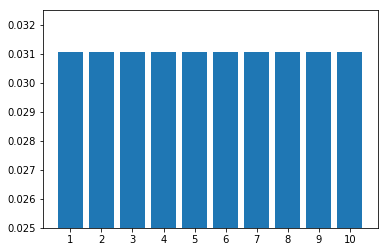

In [97]:
#Getting final val_loss
bar_nam = [1,2,3,4,5,6,7,8,9,10]
import matplotlib.pyplot as plt
finalloss_size = {}
for k,v in val_testsize.items():
    finalloss_size[k] = val_testsize[0.01][-1]
#print(finalloss_size)
plt.bar(range(len(finalloss_size)), list(finalloss_size.values()), align='center')
#plt.xticks(range(len(finalloss_size)), list(finalloss_size.keys()))
plt.xticks(range(len(finalloss_size)), bar_nam)

# # for python 2.x:
# plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# plt.xticks(range(len(D)), D.keys())  # in python 2.x
plt.ylim((0.025,.0325))
plt.show()

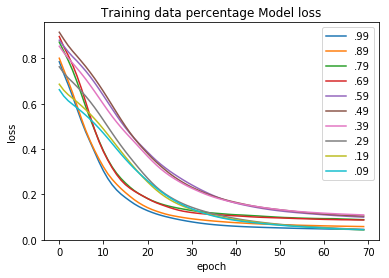

In [85]:
#Plotting loss vs epoch of different training set sizes
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#print(history.history.keys())
# "Loss"
for k, v in val_testsize.items():
    #print(k)
    plt.plot(val_testsize[k])
#plt.plot(val_testsize[0.01])
#plt.plot(val_testsize[0.51])
plt.title('Training data percentage Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['.99', '.89', '.79','.69','.59','.49','.39','.29','.19','.09'], loc='upper right')
plt.show()



## Stats of original model

In [36]:
"""
y_pred = p_model.predict(X_testP)
#print(y_pred[1])
#print(X_testP[1])
#give it a seed 
#Averaging down the columns first (metrics), which converts it to 1 error per metric, then averages that (one row)
mse = np.mean(np.mean(np.square(y_pred-X_testV),axis=0))
rmse = np.sqrt(mse)

normX_testV = np.mean(np.mean(np.square(X_testV),axis=0))

#relative to the full scale of all the test data - 3x bigger because it's one number scaling across all metrics
mse_relative = np.mean(np.mean(np.square(y_pred-X_testV),axis=0))/normX_testV
mspe = np.mean(np.mean(np.square(y_pred-X_testV),axis=0))/normX_testV ## ask bethany
rmse_relative = np.sqrt(mspe)

#left out the mean, i would get the error rate for each metric
#first show val error decreasings as training data increases
#second show that val error can decreases earlier with active learning implementation

print("MSE:", mse)
print("RMSE:", rmse)
print("MSPE:", mspe)"""

'\ny_pred = p_model.predict(X_testP)\n#print(y_pred[1])\n#print(X_testP[1])\n#give it a seed \n#Averaging down the columns first (metrics), which converts it to 1 error per metric, then averages that (one row)\nmse = np.mean(np.mean(np.square(y_pred-X_testV),axis=0))\nrmse = np.sqrt(mse)\n\nnormX_testV = np.mean(np.mean(np.square(X_testV),axis=0))\n\n#relative to the full scale of all the test data - 3x bigger because it\'s one number scaling across all metrics\nmse_relative = np.mean(np.mean(np.square(y_pred-X_testV),axis=0))/normX_testV\nmspe = np.mean(np.mean(np.square(y_pred-X_testV),axis=0))/normX_testV ## ask bethany\nrmse_relative = np.sqrt(mspe)\n\n#left out the mean, i would get the error rate for each metric\n#first show val error decreasings as training data increases\n#second show that val error can decreases earlier with active learning implementation\n\nprint("MSE:", mse)\nprint("RMSE:", rmse)\nprint("MSPE:", mspe)'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


N = 112
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, np.sqrt(np.mean(np.square(y_pred -X_testV),axis=0)), width)

#Showing which metrics are more difficult to acquire
plt.ylabel('RMSE')
plt.title('RMSE of 112 Metrics')

plt.savefig('RMSE_metrics.png', bbox_inches='tight')
plt.show()


In [ ]:
rmse_vals = np.sqrt(np.mean(np.square(y_pred -X_testV),axis=0))

In [58]:
h_model = my_model()
history = h_model.fit(X_trainP, X_trainV, epochs=200, batch_size=10000,  verbose=1, validation_split=0.2)


Train on 13172 samples, validate on 3293 samples
Epoch 1/200
13172/13172 [==============================] - 1s 73us/step - loss: 0.8130 - mean_squared_error: 0.8130 - mean_absolute_error: 0.5051 - val_loss: 0.8758 - val_mean_squared_error: 0.8758 - val_mean_absolute_error: 0.4941
Epoch 2/200
13172/13172 [==============================] - 0s 8us/step - loss: 0.7593 - mean_squared_error: 0.7593 - mean_absolute_error: 0.4812 - val_loss: 0.8269 - val_mean_squared_error: 0.8269 - val_mean_absolute_error: 0.4760
Epoch 3/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.7138 - mean_squared_error: 0.7138 - mean_absolute_error: 0.4642 - val_loss: 0.7847 - val_mean_squared_error: 0.7847 - val_mean_absolute_error: 0.4630
Epoch 4/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.6733 - mean_squared_error: 0.6733 - mean_absolute_error: 0.4516 - val_loss: 0.7418 - val_mean_squared_error: 0.7418 - val_mean_absolute_error: 0.4500
Epoch 5/200
13172/13172 [=

13172/13172 [==============================] - 0s 8us/step - loss: 0.0532 - mean_squared_error: 0.0532 - mean_absolute_error: 0.1003 - val_loss: 0.1068 - val_mean_squared_error: 0.1068 - val_mean_absolute_error: 0.1050
Epoch 37/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.0518 - mean_squared_error: 0.0518 - mean_absolute_error: 0.0986 - val_loss: 0.1052 - val_mean_squared_error: 0.1052 - val_mean_absolute_error: 0.1033
Epoch 38/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.0506 - mean_squared_error: 0.0506 - mean_absolute_error: 0.0970 - val_loss: 0.1037 - val_mean_squared_error: 0.1037 - val_mean_absolute_error: 0.1017
Epoch 39/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.0494 - mean_squared_error: 0.0494 - mean_absolute_error: 0.0955 - val_loss: 0.1022 - val_mean_squared_error: 0.1022 - val_mean_absolute_error: 0.1003
Epoch 40/200
13172/13172 [==============================] - 0s 8us/step - loss: 0.048

13172/13172 [==============================] - 0s 9us/step - loss: 0.0298 - mean_squared_error: 0.0298 - mean_absolute_error: 0.0651 - val_loss: 0.0925 - val_mean_squared_error: 0.0925 - val_mean_absolute_error: 0.0699
Epoch 72/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.0295 - mean_squared_error: 0.0295 - mean_absolute_error: 0.0644 - val_loss: 0.0927 - val_mean_squared_error: 0.0927 - val_mean_absolute_error: 0.0695
Epoch 73/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.0292 - mean_squared_error: 0.0292 - mean_absolute_error: 0.0640 - val_loss: 0.0937 - val_mean_squared_error: 0.0937 - val_mean_absolute_error: 0.0690
Epoch 74/200
13172/13172 [==============================] - 0s 8us/step - loss: 0.0289 - mean_squared_error: 0.0289 - mean_absolute_error: 0.0635 - val_loss: 0.0941 - val_mean_squared_error: 0.0941 - val_mean_absolute_error: 0.0684
Epoch 75/200
13172/13172 [==============================] - 0s 8us/step - loss: 0.028

13172/13172 [==============================] - 0s 8us/step - loss: 0.0235 - mean_squared_error: 0.0235 - mean_absolute_error: 0.0533 - val_loss: 0.0860 - val_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.0584
Epoch 107/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.0234 - mean_squared_error: 0.0234 - mean_absolute_error: 0.0531 - val_loss: 0.0847 - val_mean_squared_error: 0.0847 - val_mean_absolute_error: 0.0582
Epoch 108/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.0233 - mean_squared_error: 0.0233 - mean_absolute_error: 0.0529 - val_loss: 0.0834 - val_mean_squared_error: 0.0834 - val_mean_absolute_error: 0.0580
Epoch 109/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.0232 - mean_squared_error: 0.0232 - mean_absolute_error: 0.0528 - val_loss: 0.0820 - val_mean_squared_error: 0.0820 - val_mean_absolute_error: 0.0579
Epoch 110/200
13172/13172 [==============================] - 0s 9us/step - loss: 0

13172/13172 [==============================] - 0s 8us/step - loss: 0.0211 - mean_squared_error: 0.0211 - mean_absolute_error: 0.0485 - val_loss: 0.0709 - val_mean_squared_error: 0.0709 - val_mean_absolute_error: 0.0536
Epoch 142/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.0211 - mean_squared_error: 0.0211 - mean_absolute_error: 0.0484 - val_loss: 0.0708 - val_mean_squared_error: 0.0708 - val_mean_absolute_error: 0.0536
Epoch 143/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.0483 - val_loss: 0.0704 - val_mean_squared_error: 0.0704 - val_mean_absolute_error: 0.0536
Epoch 144/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.0210 - mean_squared_error: 0.0210 - mean_absolute_error: 0.0483 - val_loss: 0.0705 - val_mean_squared_error: 0.0705 - val_mean_absolute_error: 0.0535
Epoch 145/200
13172/13172 [==============================] - 0s 9us/step - loss: 0

13172/13172 [==============================] - 0s 9us/step - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.0462 - val_loss: 0.0637 - val_mean_squared_error: 0.0637 - val_mean_absolute_error: 0.0515
Epoch 177/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0.0461 - val_loss: 0.0639 - val_mean_squared_error: 0.0639 - val_mean_absolute_error: 0.0513
Epoch 178/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0.0460 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.0513
Epoch 179/200
13172/13172 [==============================] - 0s 9us/step - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0.0460 - val_loss: 0.0634 - val_mean_squared_error: 0.0634 - val_mean_absolute_error: 0.0512
Epoch 180/200
13172/13172 [==============================] - 0s 9us/step - loss: 0

In [59]:
#histogram of different metrics
#RMSE shows that there is around a 1% error in predicting V100 metrics from P100 data

In [60]:
print(history.history.keys())

dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


dict_keys(['val_loss', 'val_mean_squared_error', 'val_mean_absolute_error', 'loss', 'mean_squared_error', 'mean_absolute_error'])


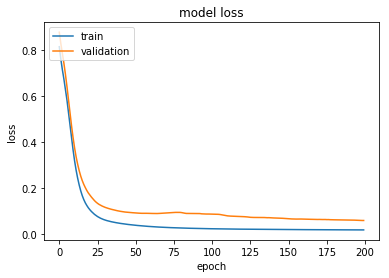

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()